# 決定木モデルによる分類

In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print('sklearn version : ' + sklearn.__version__)

sklearn version : 0.24.0


In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [4]:
tree.score(X_train, y_train)

1.0

In [5]:
tree.score(X_test, y_test)

0.9370629370629371

## 決定木モデルの可視化

決定木のモデルは可視化を行うことができる。  
このようにすることで多くの人にモデルの内容を知ってもらうことができる。  

決定木モデルをパラメータデフォルト値で行った場合、訓練データの内容を学習するために決定木が複雑になり過学習されることが多い。  
図のsampleはそのモデルに何個のデータが通るかを表し、value=[X,Y]はそのデータがどの割合で2分岐したのかを示す。  
X,Yの差がとても大きく、どちらかが0に近い場合、その分岐があったとしても有効に機能する機会は少なく役に立ちにくい分岐であることがわかる。  
例)  
samples = 142  
vlaue = [134, 8]  

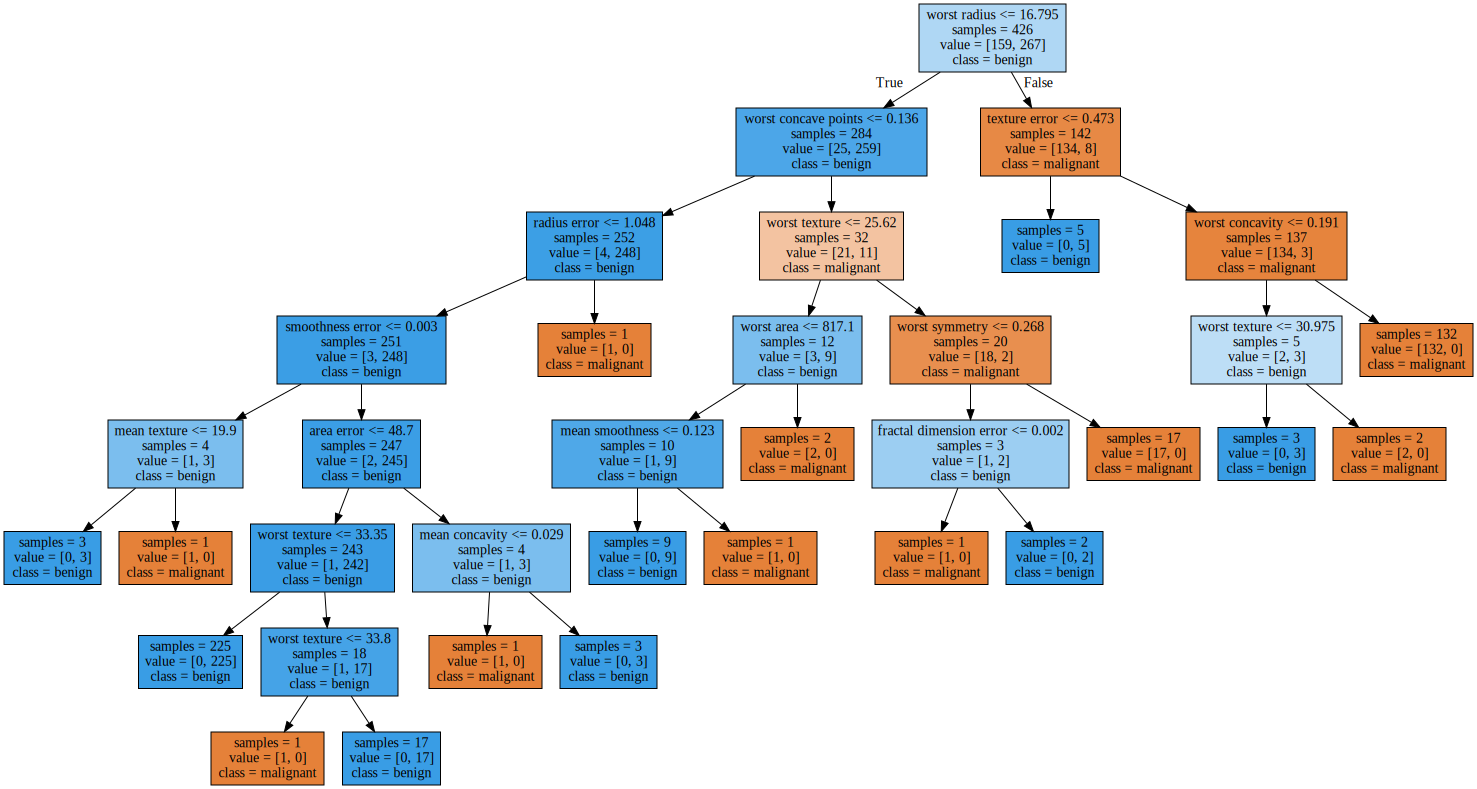

In [6]:
import graphviz
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="data\\tree.dot", class_names=["malignant", "benign"], feature_names=cancer.feature_names, impurity=False, filled=True)

#NOTE: 画像を表示するためには下記URLからgraphvizのexeファイルをダウンロードし、PATHを通しておく必要ある
#https://www2.graphviz.org/Packages/stable/windows/
with open("data\\tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## 決定木の複雑さの制御

過学習を抑えるためパラメータを調整することができる。  
パラメータの1つに深さの制限を加えることができる。  

In [7]:
tree4 = DecisionTreeClassifier(max_depth=4, random_state=0)
tree4.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

In [8]:
tree4.score(X_train, y_train)

0.9882629107981221

In [9]:
tree4.score(X_test, y_test)

0.951048951048951

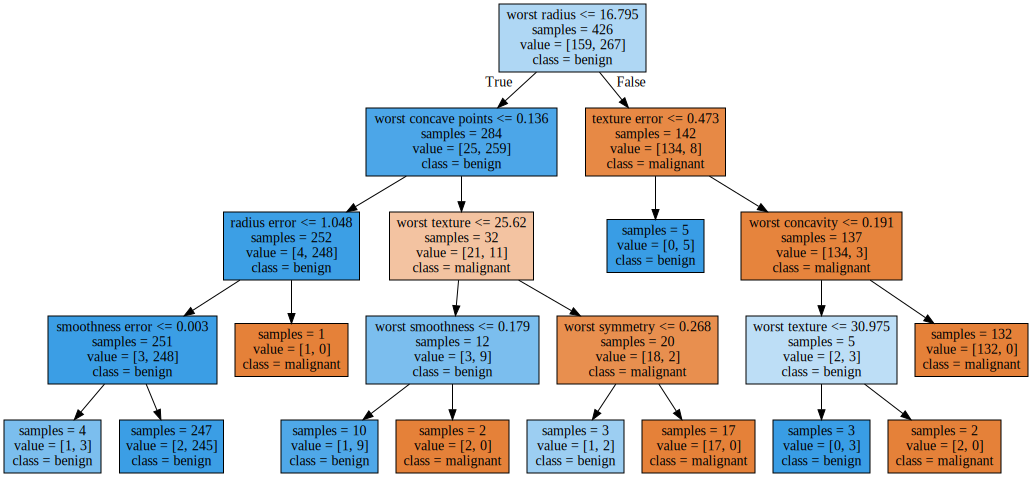

In [10]:
import graphviz
from sklearn.tree import export_graphviz
export_graphviz(tree4, out_file="data\\tree4.dot", class_names=["malignant", "benign"], feature_names=cancer.feature_names, impurity=False, filled=True)

#NOTE: 画像を表示するためには下記URLからgraphvizのexeファイルをダウンロードし、PATHを通しておく必要ある
#https://www2.graphviz.org/Packages/stable/windows/
with open("data\\tree4.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 分割時の指標

決定木アルゴリズムが分割を行う際の指標として不純度がある。  
不純度の評価関数を変えることで分割の内容が変化する。

### ジニ不純度
誤分類の確率を指標にしてそれを最小化する。
正解と不正解のノードが同数含まれるときに最大となる。
$$
IG(t) = \sum_{i=0}^{c}p(i|t)(1-p(i|t))
$$
ここで、  
p(i|t)・・・特定のノードtにおいて、iに所属する割合  
c・・・分類数  

### エントロピー不純度
エントロピーを最小化する。
ジニ不純度と同様に正解と不正解のノードが同数含まれるときに最大となる。
$$
IH(t) = -\sum_{i=0}^{c}p(i|t) \log_2 p(i|t)
$$

### 分類誤差
分類の誤差を最小にする。  
ノードのクラス確率の変化にあまり敏感でないため、決定木を成長させるのに適していない。  

## 特徴量の重要性の確認

特徴量のどの分岐が分類にとって重要なのかを確認することができる。

In [11]:
tree.feature_importances_

array([0.        , 0.00752597, 0.        , 0.        , 0.00903116,
       0.        , 0.00752597, 0.        , 0.        , 0.        ,
       0.00975731, 0.04630969, 0.        , 0.00238745, 0.00231135,
       0.        , 0.        , 0.        , 0.        , 0.00668975,
       0.69546322, 0.05383211, 0.        , 0.01354675, 0.        ,
       0.        , 0.01740312, 0.11684357, 0.01137258, 0.        ])

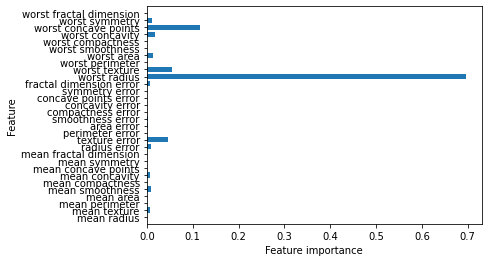

In [12]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(tree)